# DNA to DNA autoencoder
by Ivan Klimuk

In [1]:
# imports and stuff

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Dropout, Lambda
from keras.models import Model
from keras import backend as B
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import metrics as m

/Users/ivan/Documents/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Define different evaluation metrics:

In [2]:
# custom evaluation metric (ratio of mistake distance to the length of the original vector)

def dist_error(y_true, y_pred):
    dist = B.sqrt(B.sum((y_true - y_pred) ** 2))
    y_length = B.sqrt(B.sum(y ** 2))
    
    return dist / y_length

In [3]:
# evaluation metric (the R2 coefficient of determination)

def R2_score(y_true, y_pred):
    SS_res =  B.sum(B.square(y_true - y_pred)) 
    SS_tot = B.sum(B.square(y_true - B.mean(y_true)))
    
    return (1 - SS_res / (SS_tot + B.epsilon()))

### Load the data:

In [11]:
object_len = 32  # is necessary to exclude the first column

DNA = np.loadtxt('./hta2.txt', skiprows=1, usecols=range(1, object_len + 1))

print('Random DNA object:\n', DNA[np.random.choice(range(0, len(DNA)))])

Random DNA object:
 [3.416 3.718 3.656 3.838 3.747 3.638 3.65  3.627 4.466 3.642 3.987 3.974
 3.749 3.639 3.672 3.999 4.394 3.785 3.864 3.806 4.22  3.55  3.53  3.651
 3.589 4.422 3.7   3.867 4.128 3.599 3.554 3.844]


In [12]:
# find out the maximal value accross the DNA features

DNA_max = np.amax(DNA)
print('Maximal DNA value:', DNA_max)

Maximal DNA value: 13.323


### Define the Autoencoder architecture

In [15]:
data_input = Input(shape=(DNA.shape[1],))

normalized_input = Lambda(lambda x: x / DNA_max)(data_input)  # this lambda layer normalizes the values of the input by the maximal value in the dataset

encoded = Dense(16, activation='relu')(normalized_input)

normalized_output = Dense(32, activation='sigmoid')(encoded)

data_output = Lambda(lambda x: x * DNA_max)(normalized_output)  # therefore this layer reverts the normalization

DNA_to_DNA = Model(data_input, data_output)

DNA_to_DNA.compile(optimizer='rmsprop',
                   loss='mse',
                   metrics=[R2_score])

### Train the model

In [16]:
# model training

training_history = DNA_to_DNA.fit(x=DNA, y=DNA,
                                  epochs=100,
                                  shuffle=True,
                                  validation_split=0.2,
                                  verbose=2)

Train on 16026 samples, validate on 4007 samples
Epoch 1/100
 - 1s - loss: 1.7122 - R2_score: 0.0441 - val_loss: 0.6066 - val_R2_score: 0.6499
Epoch 2/100
 - 0s - loss: 0.2361 - R2_score: 0.8667 - val_loss: 0.1538 - val_R2_score: 0.9123
Epoch 3/100
 - 0s - loss: 0.1504 - R2_score: 0.9146 - val_loss: 0.1281 - val_R2_score: 0.9265
Epoch 4/100
 - 0s - loss: 0.1308 - R2_score: 0.9259 - val_loss: 0.1066 - val_R2_score: 0.9391
Epoch 5/100
 - 0s - loss: 0.1187 - R2_score: 0.9330 - val_loss: 0.1160 - val_R2_score: 0.9332
Epoch 6/100
 - 0s - loss: 0.1095 - R2_score: 0.9379 - val_loss: 0.1086 - val_R2_score: 0.9377
Epoch 7/100
 - 0s - loss: 0.1030 - R2_score: 0.9411 - val_loss: 0.0880 - val_R2_score: 0.9495
Epoch 8/100
 - 0s - loss: 0.0973 - R2_score: 0.9450 - val_loss: 0.0996 - val_R2_score: 0.9428
Epoch 9/100
 - 0s - loss: 0.0928 - R2_score: 0.9474 - val_loss: 0.0851 - val_R2_score: 0.9511
Epoch 10/100
 - 0s - loss: 0.0885 - R2_score: 0.9498 - val_loss: 0.0787 - val_R2_score: 0.9547
Epoch 11/1

In [38]:
# save the weights of our trained model

DNA_weights = './models/dna_to_dna.h5'
DNA_to_DNA.save_weights(DNA_weights)

### Estimate the results

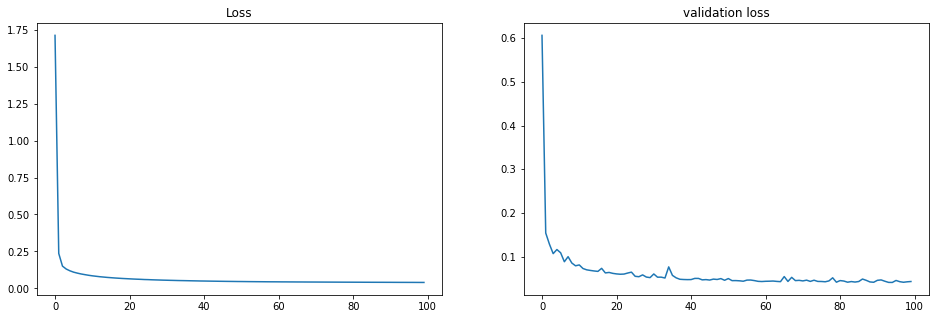

In [23]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(training_history.history['val_loss'])
plt.title('validation loss')

plt.show()

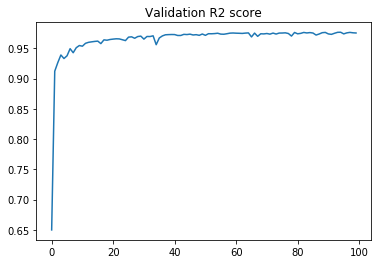

In [24]:
plt.plot(training_history.history['val_R2_score'])
plt.title('Validation R2 score')
plt.show()

In [26]:
# look at a random object and it's predicted values

n = np.random.choice(range(len(DNA)))

print('Original object: ', DNA[n])
print()
print('Predicted object: ', DNA_to_DNA.predict(np.array([DNA[n]])))

Original object:  [6.081 5.998 5.926 5.47  5.851 6.086 5.897 6.132 5.687 6.075 5.719 6.01
 6.128 6.233 5.625 5.656 5.601 5.87  5.595 5.489 5.646 5.504 5.916 6.962
 6.116 6.074 7.402 6.306 5.974 6.256 6.8   6.307]

Predicted object:  [[5.9236903 5.7936687 5.901278  5.488331  5.9843493 5.8380814 5.802903
  5.991559  5.5642242 5.861719  5.656318  6.051563  6.013971  6.10403
  5.5109215 5.458443  5.501754  5.668607  5.622676  5.4294553 5.519645
  5.5514703 5.658404  6.4862356 6.1821723 6.3344607 7.4033847 6.4735208
  5.9647913 6.173725  6.619918  6.1378117]]
